Dataset Head:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2     

<ipython-input-36-f19391d16df3>:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=data, palette='viridis')


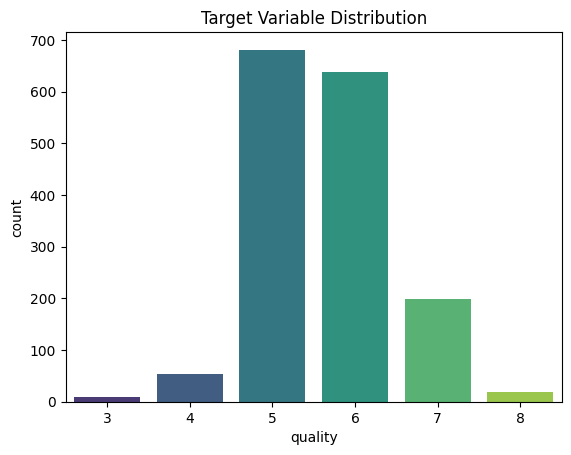


Class Distribution After SMOTE:
quality
False    684
True     684
Name: count, dtype: int64

Best Hyperparameters for XGBoost:
{'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200}


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Model Evaluation:
Random Forest Accuracy:  0.79375
AdaBoost Accuracy:  0.709375
GradientBoosting Accuracy:  0.721875
XGBoost Accuracy:  0.7875

Confusion Matrix (XGBoost):
[[112  37]
 [ 31 140]]

Classification Report (XGBoost):
              precision    recall  f1-score   support

       False       0.78      0.75      0.77       149
        True       0.79      0.82      0.80       171

    accuracy                           0.79       320
   macro avg       0.79      0.79      0.79       320
weighted avg       0.79      0.79      0.79       320

ROC-AUC Score (XGBoost): 0.877506966521449


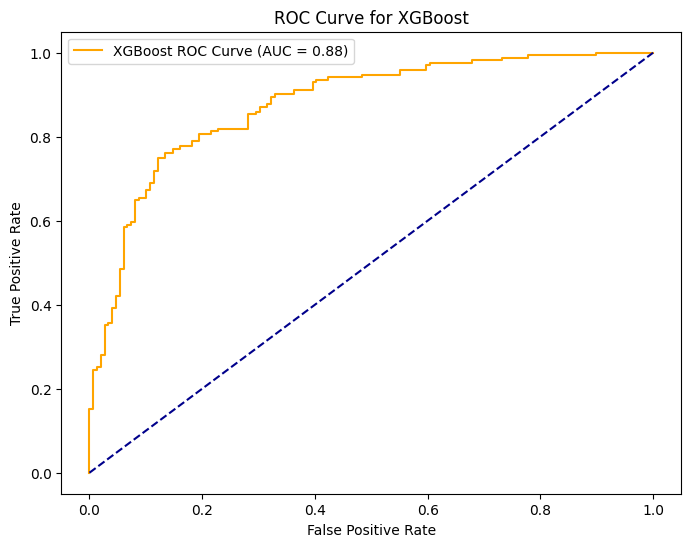

In [36]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
import xgboost as xgb

# Load the Wine Quality dataset
file_path = '/content/winequality-red.csv'  # Update your file path if necessary
data = pd.read_csv(file_path, delimiter=';')

# Check the dataset
print("Dataset Head:")
print(data.head())

print("\nTarget Variable Distribution:")
sns.countplot(x='quality', data=data, palette='viridis')
plt.title("Target Variable Distribution")
plt.show()

# Feature engineering: Binary classification for quality > 5
X = data.drop('quality', axis=1)
y = data['quality'] > 5  # Good wine = True (quality > 5), otherwise False

# Standardizing the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=1, stratify=y)

# Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("\nClass Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Define classifiers
rfc = RandomForestClassifier(n_estimators=200, random_state=1, class_weight='balanced')
abc = AdaBoostClassifier(n_estimators=200, learning_rate=0.01, random_state=1)
gbc = GradientBoostingClassifier(n_estimators=200, learning_rate=0.01, random_state=1)
xgb_clf = xgb.XGBClassifier(random_state=1)

# Hyperparameter tuning for XGBoost using GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
}

grid_search = GridSearchCV(xgb.XGBClassifier(random_state=42), param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)

# Best parameters for XGBoost
print("\nBest Hyperparameters for XGBoost:")
print(grid_search.best_params_)

# Train models with resampled data
rfc.fit(X_train_resampled, y_train_resampled)
abc.fit(X_train_resampled, y_train_resampled)
gbc.fit(X_train_resampled, y_train_resampled)
xgb_clf = grid_search.best_estimator_
xgb_clf.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_rfc = rfc.predict(X_test)
y_pred_abc = abc.predict(X_test)
y_pred_gbc = gbc.predict(X_test)
y_pred_xgb = xgb_clf.predict(X_test)

# Accuracy Scores
print("\nModel Evaluation:")
print("Random Forest Accuracy: ", accuracy_score(y_test, y_pred_rfc))
print("AdaBoost Accuracy: ", accuracy_score(y_test, y_pred_abc))
print("GradientBoosting Accuracy: ", accuracy_score(y_test, y_pred_gbc))
print("XGBoost Accuracy: ", accuracy_score(y_test, y_pred_xgb))

# Confusion Matrix and Classification Report for XGBoost
print("\nConfusion Matrix (XGBoost):")
cm = confusion_matrix(y_test, y_pred_xgb)
print(cm)

print("\nClassification Report (XGBoost):")
print(classification_report(y_test, y_pred_xgb))

# ROC-AUC Score
y_pred_proba_xgb = xgb_clf.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba_xgb)
print("ROC-AUC Score (XGBoost):", roc_auc)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba_xgb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label='XGBoost ROC Curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for XGBoost')
plt.legend()
plt.show()


In [45]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Define individual models
rfc = RandomForestClassifier(n_estimators=200, random_state=1)
abc = AdaBoostClassifier(n_estimators=200, random_state=1, learning_rate=0.01)
gbc = GradientBoostingClassifier(n_estimators=200, random_state=1, learning_rate=0.01)
xgb_clf = xgb.XGBClassifier(n_estimators=200, random_state=1, learning_rate=0.01)

# Combine models using Voting Classifier
voting_clf = VotingClassifier(
    estimators=[('rf', rfc), ('ada', abc), ('gb', gbc), ('xgb', xgb_clf)],
    voting='soft'  # 'soft' for probabilities; 'hard' for majority voting
)

# Train Voting Classifier
voting_clf.fit(X_train, y_train)

# Predictions
y_pred_voting = voting_clf.predict(X_test)

# Evaluate the Voting Classifier
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_voting))
print("\nClassification Report:")
print(classification_report(y_test, y_pred_voting))

# Compare Voting Classifier Accuracy
voting_accuracy = accuracy_score(y_test, y_pred_voting)
print(f"Voting Classifier Accuracy: {voting_accuracy:.2f}")


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Confusion Matrix:
[[110  39]
 [ 33 138]]

Classification Report:
              precision    recall  f1-score   support

       False       0.77      0.74      0.75       149
        True       0.78      0.81      0.79       171

    accuracy                           0.78       320
   macro avg       0.77      0.77      0.77       320
weighted avg       0.77      0.78      0.77       320

Voting Classifier Accuracy: 0.78


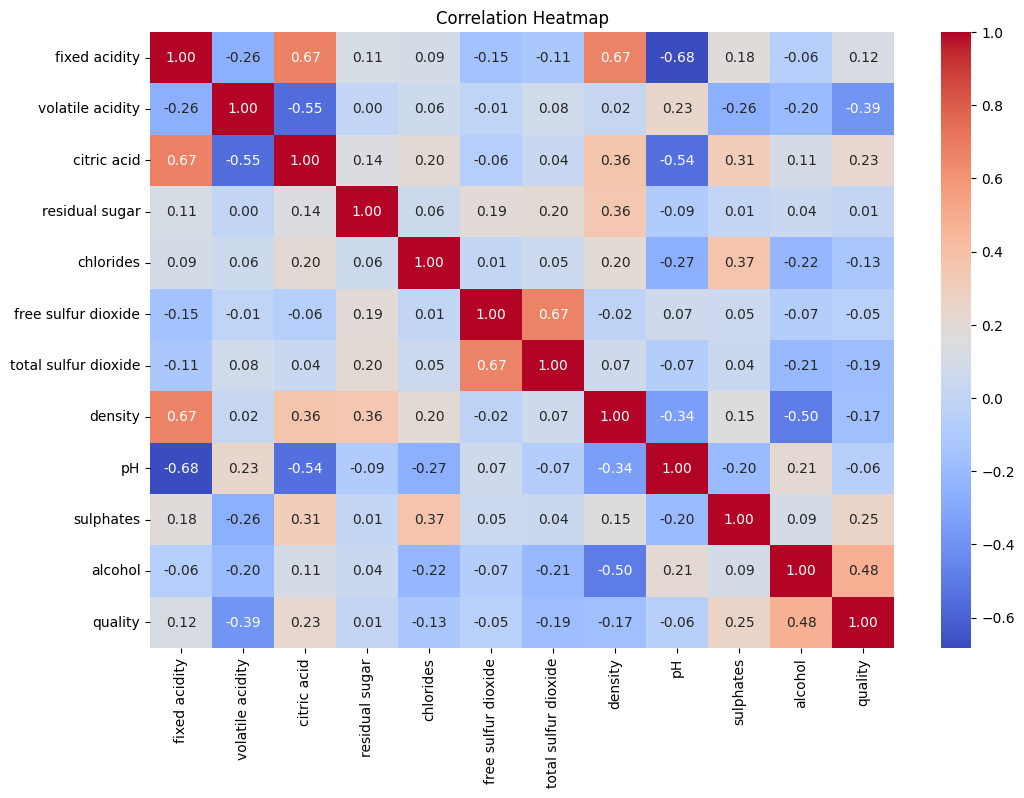

In [46]:
# Correlation matrix
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()


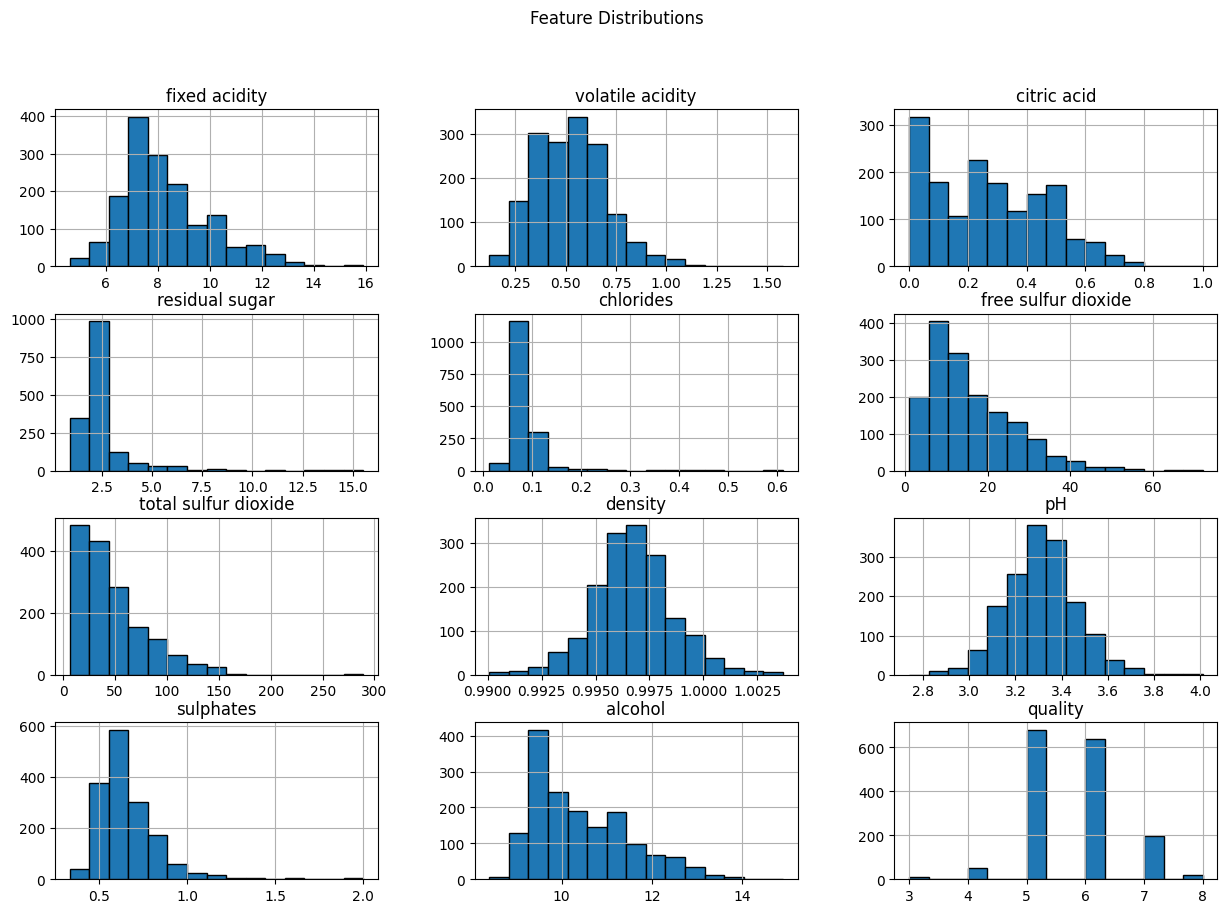

In [48]:
# Plot distribution of numerical features
data.hist(bins=15, figsize=(15, 10), edgecolor="black")
plt.suptitle("Feature Distributions")
plt.show()


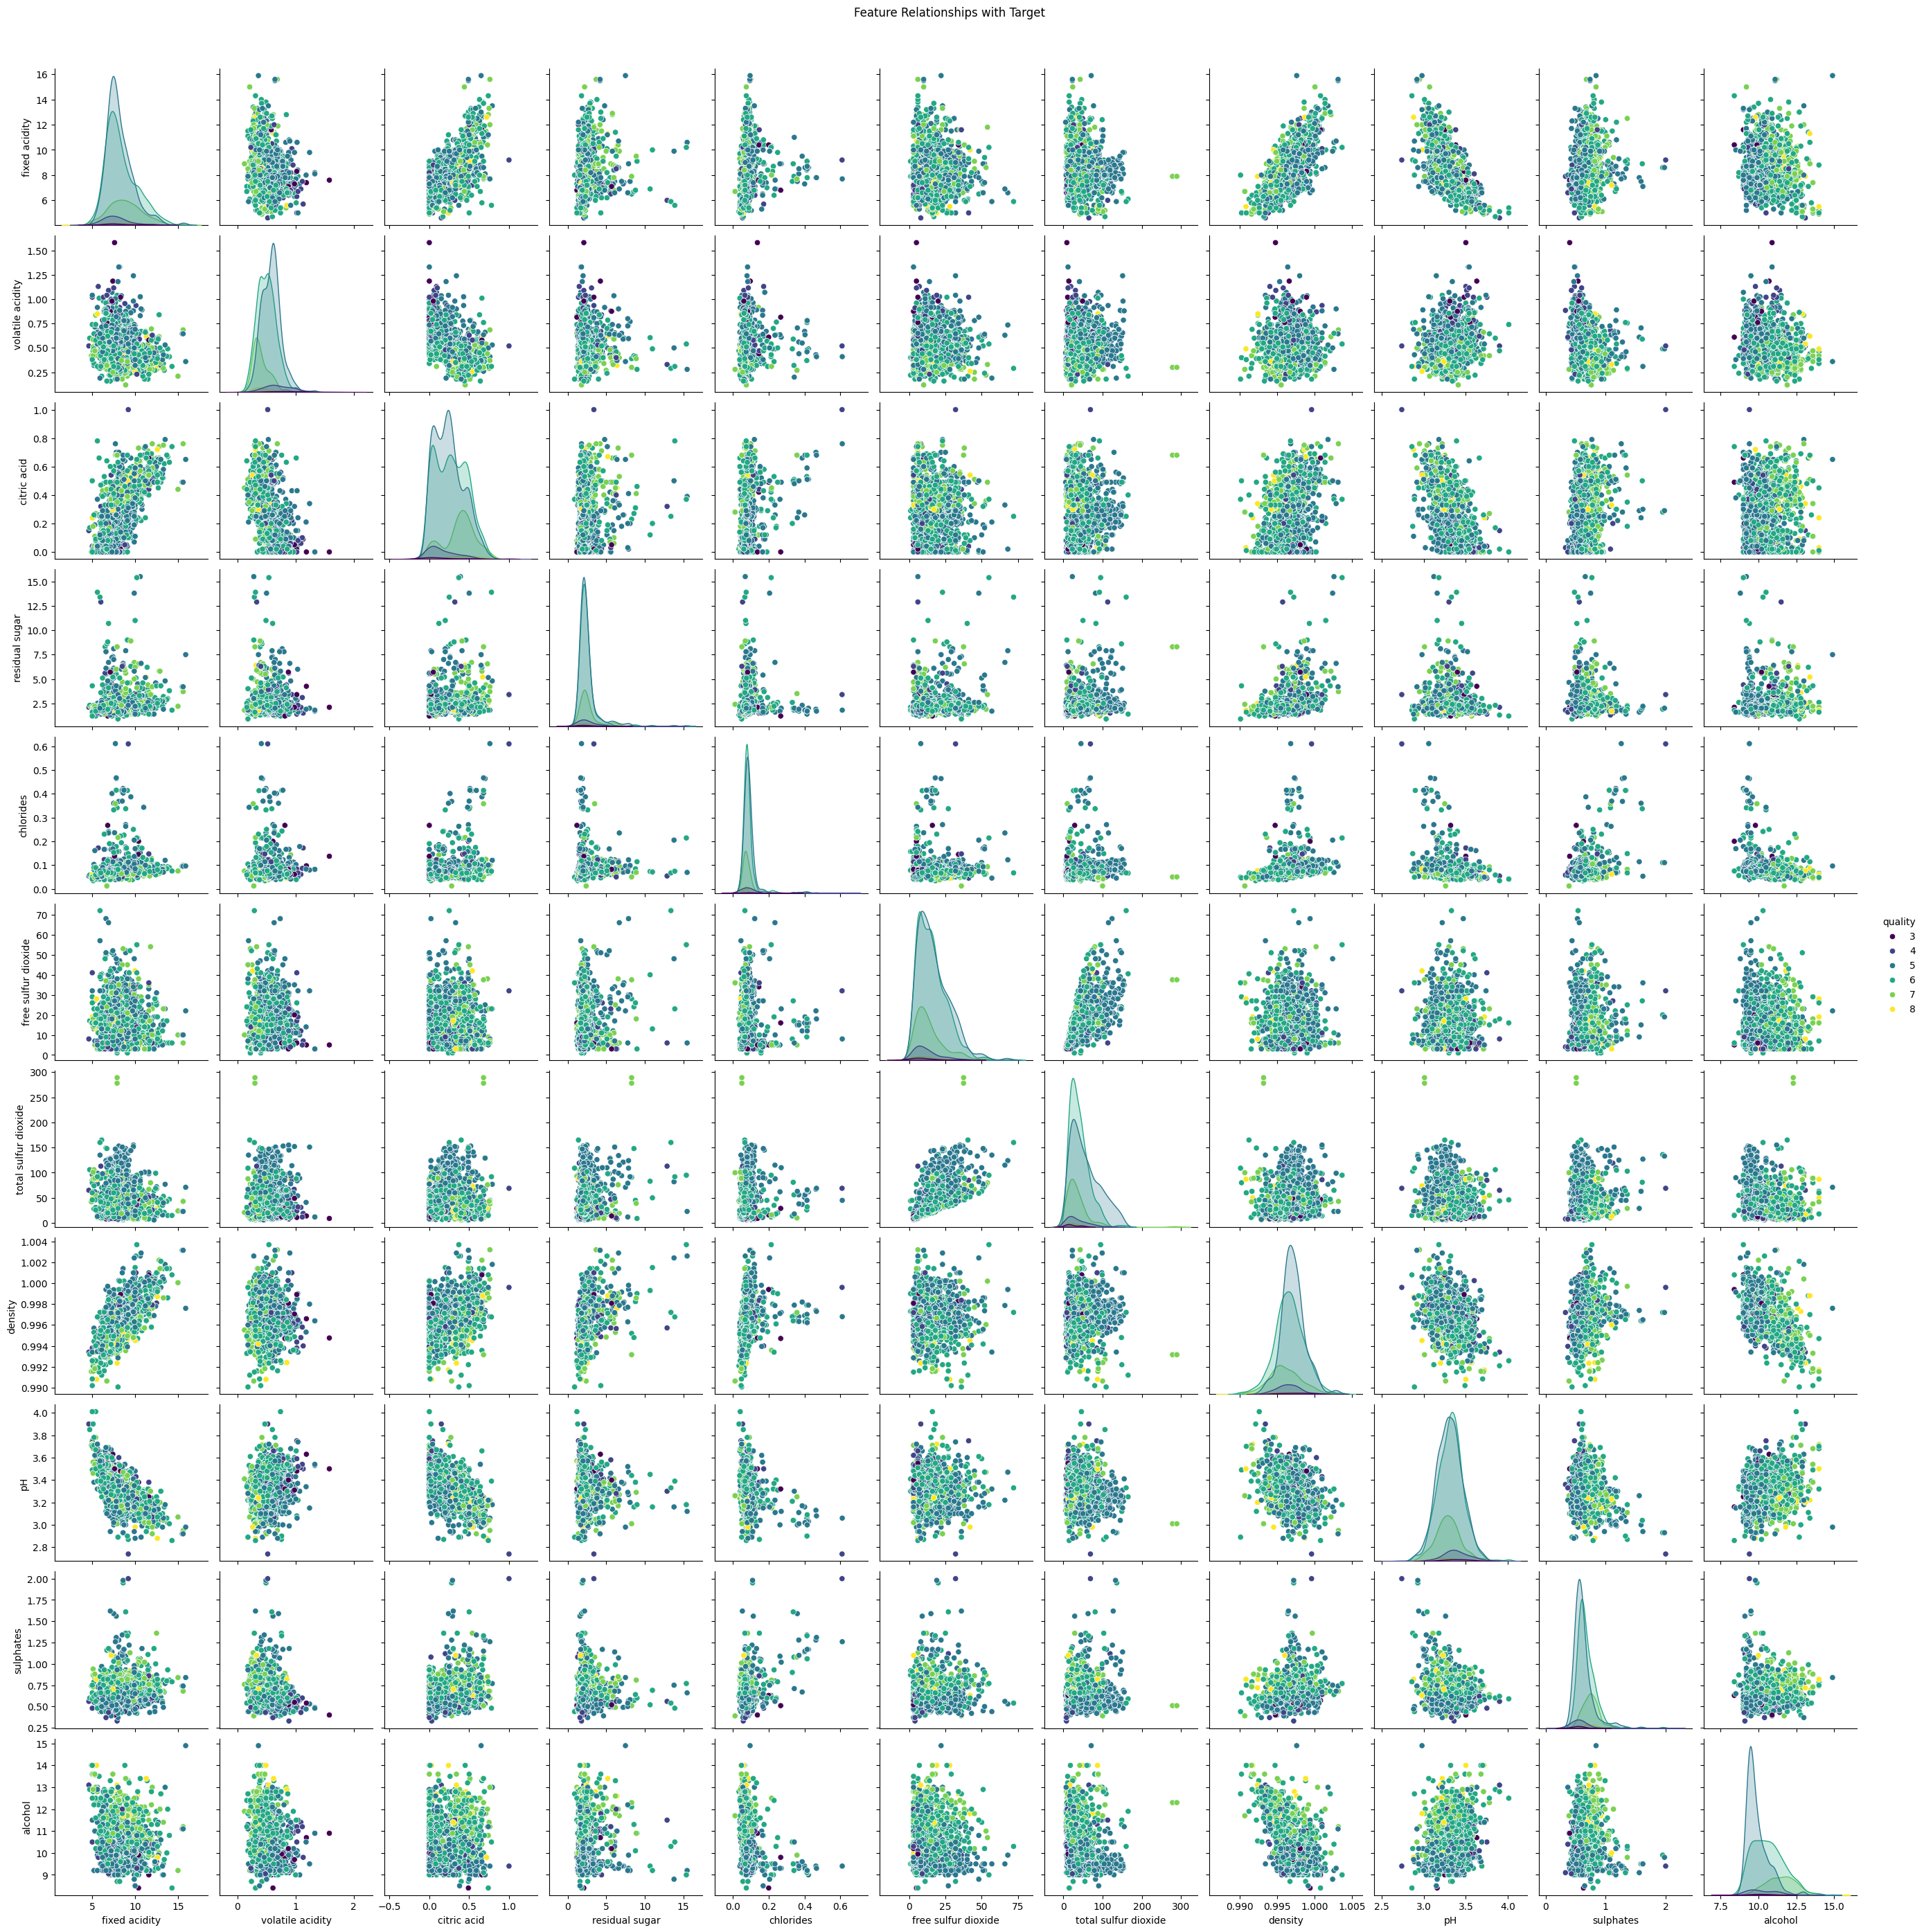

In [49]:
# Pairplot to show relationships
sns.pairplot(data, hue='quality', diag_kind='kde', palette='viridis')
plt.suptitle("Feature Relationships with Target", y=1.02)
plt.show()


<ipython-input-50-17d50971e24a>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='quality', data=data, palette='viridis')


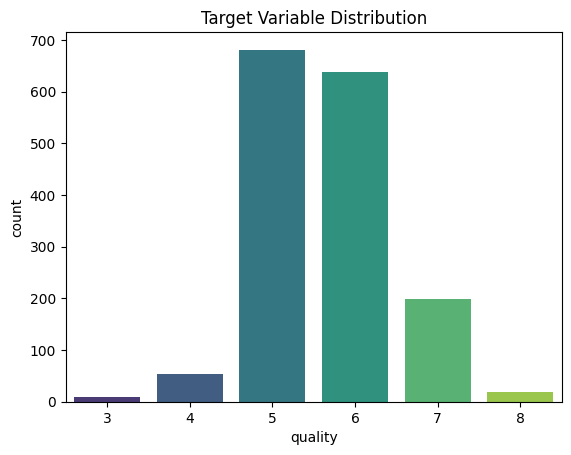

In [50]:
# Count plot for target variable distribution
sns.countplot(x='quality', data=data, palette='viridis')
plt.title("Target Variable Distribution")
plt.show()


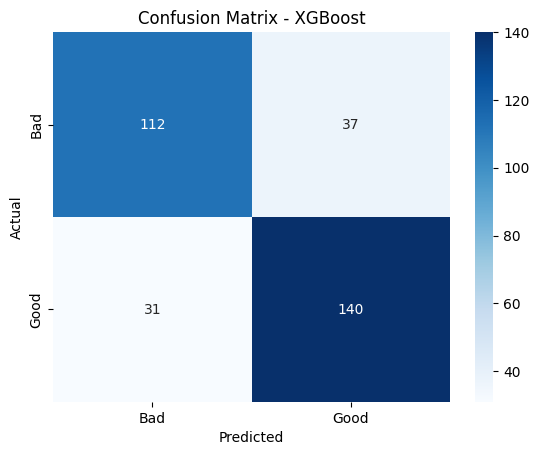

In [53]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='d', cmap='Blues', xticklabels=['Bad', 'Good'], yticklabels=['Bad', 'Good'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - XGBoost")
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
<ipython-input-57-eddda827af93>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=accuracies, palette='viridis')


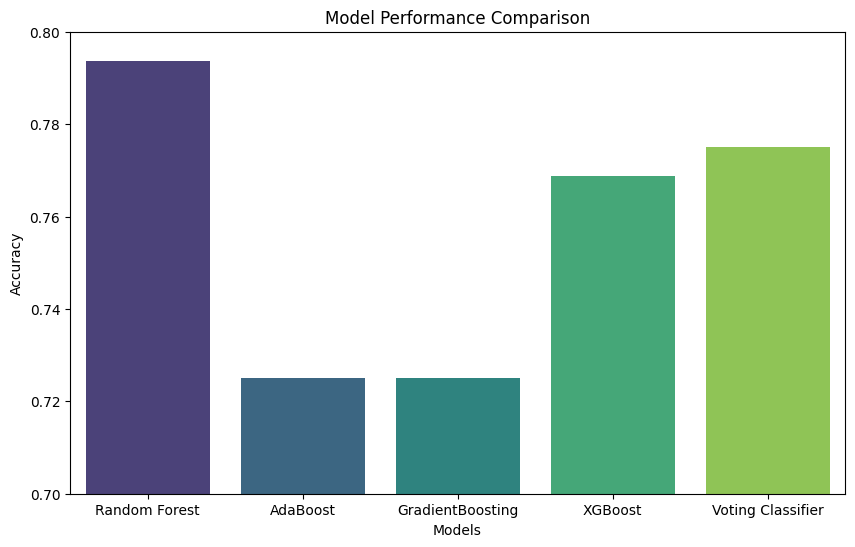

<ipython-input-57-eddda827af93>:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mini_model_names, y=mini_accuracies, palette='Blues_d')


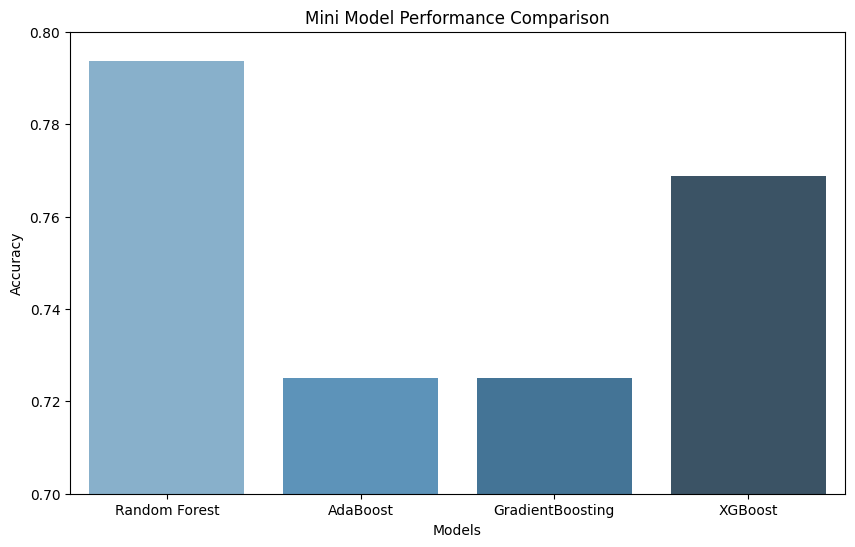

In [57]:
# Fit classifiers if not already done
rfc.fit(X_train, y_train)
abc.fit(X_train, y_train)
gbc.fit(X_train, y_train)
xgb_clf.fit(X_train, y_train)

# Accuracy of individual models and the Voting Classifier
model_names = ['Random Forest', 'AdaBoost', 'GradientBoosting', 'XGBoost', 'Voting Classifier']
accuracies = [
    accuracy_score(y_test, rfc.predict(X_test)),
    accuracy_score(y_test, abc.predict(X_test)),
    accuracy_score(y_test, gbc.predict(X_test)),
    accuracy_score(y_test, xgb_clf.predict(X_test)),
    voting_accuracy
]

# Plotting the overall model performance
plt.figure(figsize=(10, 6))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.title('Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.8)  # Adjust y-axis range for better clarity
plt.show()

# Mini Model Performance: Compare individual model performance on accuracy
mini_accuracies = [
    accuracy_score(y_test, rfc.predict(X_test)),
    accuracy_score(y_test, abc.predict(X_test)),
    accuracy_score(y_test, gbc.predict(X_test)),
    accuracy_score(y_test, xgb_clf.predict(X_test))
]

mini_model_names = ['Random Forest', 'AdaBoost', 'GradientBoosting', 'XGBoost']

# Plotting the mini model performance
plt.figure(figsize=(10, 6))
sns.barplot(x=mini_model_names, y=mini_accuracies, palette='Blues_d')
plt.title('Mini Model Performance Comparison')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0.7, 0.8)  # Adjust y-axis range for clarity
plt.show()
